# Analyzing Experimental Data: Statistical Tests and Power

## Imports

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.power import TTestIndPower

In [4]:
chemical_reactions = pd.read_csv('chemical_reactions.csv')
chemical_reactions.sample(2)

,Catalyst,Reaction_Time
26,Palladium,39.245032
1085,Nickel,52.150208


In [5]:
hr_wellness = pd.read_csv('hr_wellness.csv')
hr_wellness.sample(2)

,Department,Wellness_Program_Status
662,Sales,Not Enrolled
613,Marketing,Not Enrolled


In [6]:
investment_returns = pd.read_csv('investment_returns.csv')
investment_returns.sample(2)

,Strategy_Type,Annual_Return
568,Fundamental,5.125321
580,Fundamental,6.509823


In [7]:
therapy_outcomes = pd.read_csv('therapy_outcomes.csv')
therapy_outcomes.sample(2)

,Therapy_Type,Anxiety_Reduction
616,DBT,15.546974
699,ACT,14.075489


In [24]:
toy_durability = pd.read_csv('toy_durability.csv')
toy_durability.sample(2)

,Toy_Type,Durability_Score
1256,Educational,83.3
1208,Educational,78.0


## Choosing the right statistical test

### Choosing the right test: petrochemicals

In [8]:
catalyst_types = ['Palladium', 'Platinum', 'Nickel']

# Collect reaction times for each catalyst into a list
groups = [chemical_reactions[chemical_reactions['Catalyst'] == catalyst]['Reaction_Time'].copy() for catalyst in catalyst_types]

In [9]:
catalyst_types = ['Palladium', 'Platinum', 'Nickel']

# Collect reaction times for each catalyst into a list
groups = [chemical_reactions[chemical_reactions['Catalyst'] == catalyst]['Reaction_Time'].copy() for catalyst in catalyst_types]

# Perform the one-way ANOVA across the three groups
f_stat, p_val = f_oneway(*groups)
print(f"F-statistic: {f_stat}, P-value: {p_val}")

F-statistic: 478.7412625615453, P-value: 4.710677600047866e-151


### Choosing the right test: human resources

In [10]:
# Create a contingency table
contingency_table = pd.crosstab(
  hr_wellness['Department'], 
  hr_wellness['Wellness_Program_Status']
)

In [11]:
# Create a contingency table
contingency_table = pd.crosstab(
  hr_wellness['Department'], 
  hr_wellness['Wellness_Program_Status']
)

# Perform the chi-square test of association
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2-statistic: {chi2_stat}, P-value: {p_val}")

Chi2-statistic: 3.4775739037369617, P-value: 0.17573344450112738


### Choosing the right test: finance

In [12]:
# Separate the annual returns by strategy type
quantitative_returns = investment_returns[investment_returns['Strategy_Type'] == 'Quantitative']['Annual_Return'].copy()
fundamental_returns = investment_returns[investment_returns['Strategy_Type'] == 'Fundamental']['Annual_Return'].copy()

In [13]:
# Separate the annual returns by strategy type
quantitative_returns = investment_returns[investment_returns['Strategy_Type'] == 'Quantitative']['Annual_Return'].copy()
fundamental_returns = investment_returns[investment_returns['Strategy_Type'] == 'Fundamental']['Annual_Return'].copy()

# Perform the independent samples t-test between the two groups
t_stat, p_val = ttest_ind(quantitative_returns, fundamental_returns)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

T-statistic: 7.784788496693728, P-value: 2.0567003424807146e-14


## Post-hoc analysis following ANOVA

### Anxiety treatments ANOVA

In [15]:
# Pivot to view the mean anxiety reduction for each therapy
pivot_table = therapy_outcomes.pivot_table(
    values='Anxiety_Reduction', 
    index='Therapy_Type', 
    aggfunc='mean')
print(pivot_table)

              Anxiety_Reduction
Therapy_Type                   
ACT                   14.929210
CBT                   14.962170
DBT                   15.729264


In [17]:
# Pivot to view the mean anxiety reduction for each therapy
pivot_table = therapy_outcomes.pivot_table(
    values='Anxiety_Reduction', 
    index='Therapy_Type', 
    aggfunc="mean")
print(pivot_table)

# Create groups to prepare the data for ANOVA
therapy_types = ['CBT', 'DBT', 'ACT']
groups = [therapy_outcomes[therapy_outcomes['Therapy_Type'] == therapy]['Anxiety_Reduction'] for therapy in therapy_types]

              Anxiety_Reduction
Therapy_Type                   
ACT                   14.929210
CBT                   14.962170
DBT                   15.729264


In [18]:
# Pivot to view the mean anxiety reduction for each therapy
pivot_table = therapy_outcomes.pivot_table(
    values='Anxiety_Reduction', 
    index='Therapy_Type', 
    aggfunc="mean")
print(pivot_table)

# Create groups to prepare the data for ANOVA
therapy_types = ['CBT', 'DBT', 'ACT']
groups = [therapy_outcomes[therapy_outcomes['Therapy_Type'] == therapy]['Anxiety_Reduction'] for therapy in therapy_types]

# Conduct ANOVA
f_stat, p_val = f_oneway(*groups)
print(p_val)

              Anxiety_Reduction
Therapy_Type                   
ACT                   14.929210
CBT                   14.962170
DBT                   15.729264
0.019580062979016804


### Applying Tukey's HSD

In [21]:
# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(
    therapy_outcomes['Anxiety_Reduction'],
    therapy_outcomes['Therapy_Type'],  
    alpha=0.05
)

print(tukey_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   ACT    CBT    0.033 0.9941 -0.7136 0.7795  False
   ACT    DBT   0.8001 0.0358  0.0418 1.5583   True
   CBT    DBT   0.7671 0.0433  0.0181 1.5161   True
---------------------------------------------------


### Applying Bonferoni correction

In [23]:
p_values = []

therapy_pairs = [('CBT', 'DBT'), ('CBT', 'ACT'), ('DBT', 'ACT')]

# Conduct t-tests and collect P-values
for pair in therapy_pairs:
    group1 = therapy_outcomes[therapy_outcomes['Therapy_Type'] == pair[0]]['Anxiety_Reduction']
    group2 = therapy_outcomes[therapy_outcomes['Therapy_Type'] == pair[1]]['Anxiety_Reduction']
    t_stat, p_val = ttest_ind(group1, group2)
    p_values.append(p_val)

# Apply Bonferroni correction
print(multipletests(p_values, alpha=0.05, method='bonferroni')[1])

[0.0451996  1.         0.04607281]


## P-values, alpha, and errors

### Analyzing toy durability

In [28]:
toy_durability

,Toy_Type,Durability_Score
0,Recreational,67.2
1,Recreational,80.9
2,Recreational,69.7
3,Recreational,82.7
4,Educational,79.6
...,...,...
1895,Recreational,75.9
1896,Educational,73.0
1897,Educational,76.2
1898,Recreational,81.1


In [30]:
# Calculate mean Durability_Score for each Toy_Type
mean_durability = toy_durability.pivot_table(
  values='Durability_Score', index='Toy_Type', aggfunc='mean')
print(mean_durability)

# Perform t-test
educational_durability = toy_durability[toy_durability['Toy_Type'] == 'Educational']['Durability_Score']
recreational_durability = toy_durability[toy_durability['Toy_Type'] == 'Recreational']['Durability_Score']
t_stat, p_val = ttest_ind(educational_durability, recreational_durability)

print(p_val)

              Durability_Score
Toy_Type                      
Educational          80.100737
Recreational         79.460632
0.020313353856485136


### Visualizing durability differences

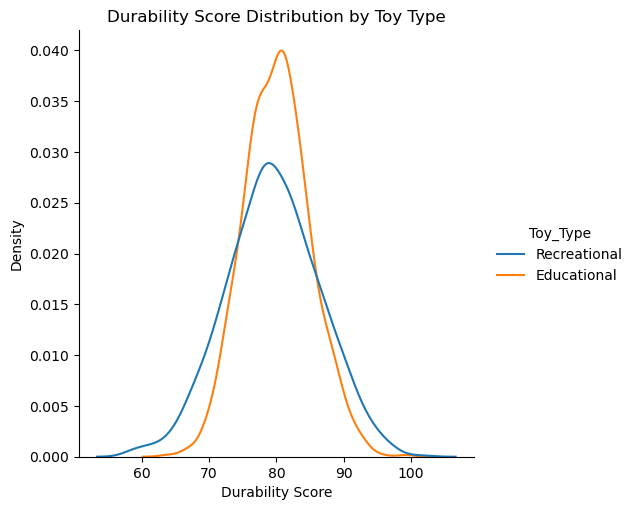

In [32]:
# Visualize the distribution of Durability_Score for each Toy_Type
sns.displot(data=toy_durability, x="Durability_Score", 
         hue="Toy_Type", kind="kde")
plt.title('Durability Score Distribution by Toy Type')
plt.xlabel('Durability Score')
plt.ylabel('Density')
plt.show()

## Power analysis: sample and effect size

### Estimating required sample size for energy study

In [34]:
# Instantiate a TTestIndPower object
power_analysis = TTestIndPower()

# Conduct a power analysis to determine the required sample size
required_n = power_analysis.solve_power(
    effect_size=0.5, 
    alpha=0.05, 
    power=0.9, 
    ratio=1)

print(required_n)

85.03128411544917
